# Unity Assignment: **Player Session Insights**
# By **Rez GodarzvandChegini** 

# Installing Pyspark dependencies

1.   Java 8
2.   Apache Spark 3.0.1 with hadoop 3.2
3.   Findspark


In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop3.2.tgz
!tar xf spark-3.0.1-bin-hadoop3.2.tgz
!pip install -q findspark

We now set the environment paths of Java and Spark home:

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop3.2"

Launch a local spark session:

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[*]").getOrCreate()
sqlContext = SQLContext(spark.sparkContext)

# Load the data

Load the dataset into your Spark egnine:

In [ ]:
import urllib.request

if not os.path.exists('assignment_data.json.bz2'):
  urllib.request.urlretrieve(
      'https://cdn.unityads.unity3d.com/assignments/assignment_data.jsonl.bz2',
      'assignment_data.json.bz2'
      )

df = spark.read.json('assignment_data.json.bz2')
df.printSchema()
df.show()

root
 |-- country: string (nullable = true)
 |-- event: string (nullable = true)
 |-- player_id: string (nullable = true)
 |-- session_id: string (nullable = true)
 |-- ts: string (nullable = true)

+-------+-----+--------------------+--------------------+-------------------+
|country|event|           player_id|          session_id|                 ts|
+-------+-----+--------------------+--------------------+-------------------+
|     PK|start|d6313e1fb7d247a6a...|674606b1-2270-428...|2016-11-22T20:40:50|
|   null|  end|20ac16ebb30a47708...|16ca9d01-d240-452...|2016-11-18T06:24:50|
|   null|  end|318e22b061b54042b...|5f933591-8cd5-414...|2016-11-16T18:01:37|
|   null|  end|29bb390d9b1b4b4b9...|ef939180-692a-484...|2016-11-13T10:38:09|
|     GH|start|a477ecabc3cc455cb...|4c55263e-66b2-481...|2016-11-29T19:31:43|
|     SK|start|1ec36a67785046b3b...|3346a60a-0989-404...|2016-11-16T05:36:16|
|     DE|start|9595af0063e94cb8a...|06830030-d091-428...|2016-11-07T01:18:09|
|   null|  end|8d0e3c

We extend completed events to also include *country* in order to run the following queries. Before doing so, let's verify that the data quality:

In [ ]:
from pyspark.sql.functions import count, countDistinct, max, coalesce

started_df = df.filter(df.event == 'start')
ended_df = df.filter(df.event == 'end')
uniq_events_df = df.groupBy('session_id', 'event').count()
uniq_starts_df = started_df.groupBy('session_id').count()
uniq_ends_df = ended_df.groupBy('session_id').count()

def print_event_uniqness_summary(df):
  max_count = df.select(max('count')).collect()[0].asDict()['max(count)']
  num_rows = df.count()
  print(f'Total # of events: {num_rows}, Max number of duplicates: {max_count}')

print("Unique (session_id, event):")
print_event_uniqness_summary(uniq_events_df)
print("Unique (session_id, 'start'):")
print_event_uniqness_summary(uniq_starts_df)
print("Unique (session_id, 'end'):")
print_event_uniqness_summary(uniq_ends_df)

Unique (session_id, event):
Total # of events: 1001169, Max number of duplicates: 1
Unique (session_id, 'start'):
Total # of events: 500584, Max number of duplicates: 1
Unique (session_id, 'end'):
Total # of events: 500585, Max number of duplicates: 1


Since we can rely on uniqueness of the session_ids, we can join the started and ended events to get the country information next to ended events for the rest of the asked queries.

In general, we want to use right join on ended events, but for the purpose of the definition of a complete being a session that has both start and end events, we need to use inner join as follows. As we can see, ended sessions also have one more member than started sessions.

We further coalesce the player ids to be retrieved from the started event in case it's missing in the ended event of the same session_id.

In [ ]:
completed_df = started_df.join(
    ended_df,
    started_df.session_id == ended_df.session_id,
    how='inner'
    ).select(
        ended_df.event,
        started_df.country,
        coalesce(ended_df.player_id,started_df.player_id).alias('player_id'),
        ended_df.session_id,
        ended_df.ts
        )

We now persist both start and end events in order to be able to query the dataframe in SQL.

In [ ]:
started_df.createOrReplaceTempView("started_sessions")
sqlContext.cacheTable("started_sessions")
completed_df.createOrReplaceTempView("completed_sessions")
sqlContext.cacheTable("completed_sessions")

# How many sessions are in the dataset?

In [ ]:
from pyspark.sql.functions import countDistinct
df.select(countDistinct("session_id").alias('total_session_count')).show()

+-------------------+
|total_session_count|
+-------------------+
|             500587|
+-------------------+



# How many sessions are completed per country?

In [ ]:
sess_per_ctry = sqlContext.sql(
    """SELECT country, COUNT(DISTINCT session_id) AS session_count
    FROM completed_sessions
    GROUP BY country
    ORDER BY session_count DESC"""
    )
sess_per_ctry.show()

+-------+-------------+
|country|session_count|
+-------+-------------+
|     IT|         2839|
|     SH|         2672|
|     AZ|         2670|
|     AT|         2655|
|     WF|         2616|
|     VA|         2602|
|     HU|         2584|
|     IL|         2563|
|     RO|         2550|
|     KR|         2535|
|     SR|         2533|
|     TO|         2521|
|     MD|         2516|
|     LS|         2475|
|     NO|         2461|
|     DE|         2440|
|     TF|         2433|
|     EG|         2431|
|     CD|         2423|
|     GS|         2414|
+-------+-------------+
only showing top 20 rows



# How many sessions are completed per player?

In [ ]:
sqlContext.sql(
    """SELECT player_id, COUNT(DISTINCT session_id) AS session_count
    FROM completed_sessions
    GROUP BY player_id
    ORDER BY session_count DESC"""
    ).show()

+--------------------+-------------+
|           player_id|session_count|
+--------------------+-------------+
|a2eb1371dc434b1c9...|           50|
|26255c2697e64a919...|           50|
|bc21a941806e41ad9...|           50|
|dcb42f3696004708a...|           50|
|d758509e77e049769...|           50|
|8500e7ecc46c414e9...|           50|
|ada4c853861d4957b...|           50|
|fd9a7f6f335745fdb...|           50|
|b0c7f160b7834a25a...|           50|
|e53d1cb155a548b3b...|           50|
|bbeaff310c1b4c878...|           50|
|e8f36a8efded42bfb...|           50|
|8982e790fad04f18a...|           50|
|24bd8188b2d241e88...|           50|
|a7c5a28df8e84b5a9...|           50|
|5534f125269940e29...|           50|
|908af531441641dc9...|           50|
|a3db69f0aa004df5b...|           50|
|821ea0f158a04c8ab...|           50|
|37370d0139544d1ca...|           50|
+--------------------+-------------+
only showing top 20 rows



# What is the country with more sessions started during 2018?

I learned that the data doesn't span over the year 2018. Instead, I took the liberty of calculating the same question over sessions started during 2016.

I intentionally skip casting *ts* to be a timestamp as with the current query, we can get what we want by processing the string format of *ts*.

In [ ]:
country_session_df = sqlContext.sql(
    """SELECT country, COUNT(DISTINCT session_id) AS session_count
      FROM started_sessions
      WHERE ts LIKE '2016%'
      GROUP BY country"""
      )
max_count = country_session_df.select(max('session_count')).collect()[0].asDict()['max(session_count)']
country_session_df.filter( f'session_count = {max_count}' ).show()

+-------+-------------+
|country|session_count|
+-------+-------------+
|     IT|         2839|
+-------+-------------+



# Plot the player sessions completed per country

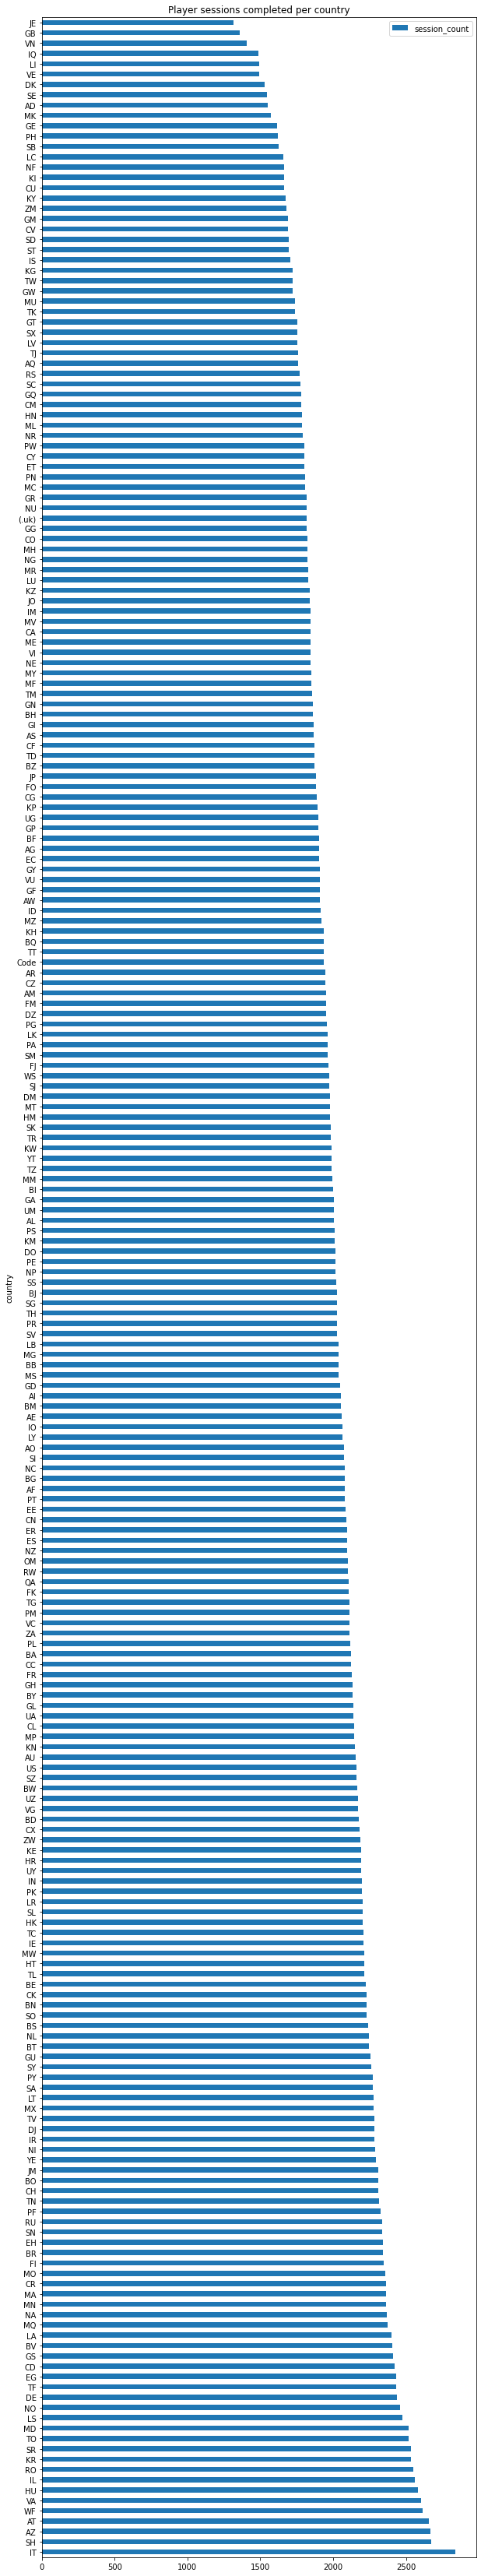

In [ ]:
import plotly as py
import plotly.graph_objs as go

sess_per_ctry.toPandas().plot.barh(
    x='country',
    y='session_count',
    title='Player sessions completed per country',
    figsize=(10,60))